In [1]:
import cv2


cap = cv2.VideoCapture(1)

num = 0

while cap.isOpened():

    succes, img = cap.read()

    k = cv2.waitKey(5)

    if k == 27:
        break
    elif k == ord('s'): # wait for 's' key to save and exit
        cv2.imwrite('C:/Users/nhoei/liveCameraPose/calibration/image' + str(num) + '.png', img)
        print("image saved!")
        num += 1

    cv2.imshow('Img 1',img)


image saved!


KeyboardInterrupt: 

c:\Users\16577\anaconda3\envs\asaassa\Lib\site-packages\numpy\linalg\linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
C:\Users\16577\AppData\Local\Temp\ipykernel_16276\2838040618.py:223: RuntimeWarning: invalid value encountered in matmul
  P = np.matmul(np.concatenate((self.K, np.zeros((3, 1))), axis=1), T)
C:\Users\16577\AppData\Local\Temp\ipykernel_16276\2838040618.py:285: RuntimeWarning: invalid value encountered in matmul
  cur_pose = cur_pose @ transf


ValueError: Expected rotation matrix, but it failed the test for inversion by transposition. np.dot(R, R.T) gives array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

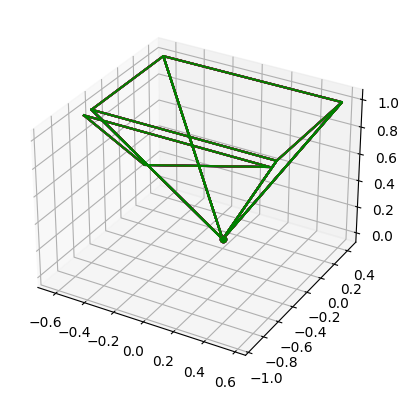

: 

In [1]:
import os
import numpy as np
import cv2
from sympy import homogeneous_order

from tqdm import tqdm
import time

from matplotlib import pyplot as plt

import pytransform3d.transformations as pt
import pytransform3d.trajectories as ptr
import pytransform3d.rotations as pr
import pytransform3d.camera as pc

from cycler import cycle
   



class CameraPoses():
    
    def __init__(self, data_dir, skip_frames, intrinsic):
        
        self.K = intrinsic
        self.extrinsic = np.array(((1,0,0,0),(0,1,0,0),(0,0,1,0)))
        self.P = self.K @ self.extrinsic
        self.orb = cv2.ORB_create(3000)
        FLANN_INDEX_LSH = 6
        index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
        search_params = dict(checks=50)
        self.flann = cv2.FlannBasedMatcher(indexParams=index_params, searchParams=search_params)
        
        self.world_points = []

        self.current_pose = None
        
    @staticmethod
    def _load_images(filepath, skip_frames):
    
        image_paths = [os.path.join(filepath, file) for file in sorted(os.listdir(filepath))]
        images = []
        
        for path in tqdm(image_paths[::skip_frames]):
            img = cv2.imread(path)
            if img is not None:
                #images.append(cv2.resize(img, (640,480)))
                images.append(img)
                
        return images
    

    @staticmethod
    def _form_transf(R, t):
        
        T = np.eye(4, dtype=np.float64)
        T[:3, :3] = R
        T[:3, 3] = t
        
        return T

    def get_world_points(self):
        return np.array(self.world_points)
    
    def get_matches(self, img1, img2):
   
        # Find the keypoints and descriptors with ORB
        kp1, des1 = self.orb.detectAndCompute(img1, None)
        kp2, des2 = self.orb.detectAndCompute(img2, None)
        # Find matches
        if len(kp1) > 6 and len(kp2) > 6:
            matches = self.flann.knnMatch(des1, des2, k=2)

            # Find the matches there do not have a to high distance
            good_matches = []
            try:
                for m, n in matches:
                    if m.distance < 0.5 * n.distance:
                        good_matches.append(m)
            except ValueError:
                pass
            
            # Draw matches
            img_matches = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1] + img2.shape[1], 3), dtype=np.uint8)
            #cv2.drawMatches(img1, kp1, img2, kp2, good_matches, img_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
            #cv2.imshow('Good Matches', img_matches)
            #cv2.waitKey(50)
            
            # Get the image points form the good matches
            #q1 = [kp1[m.queryIdx] for m in good_matches]
            #q2 = [kp2[m.trainIdx] for m in good_matches]
            q1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
            q2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])
        
            return q1, q2
        else:
            return None, None

    def get_pose(self, q1, q2):
    
        # Essential matrix
        E, mask = cv2.findEssentialMat(q1, q2, self.K)

        # Decompose the Essential matrix into R and t
        R, t = self.decomp_essential_mat_old(E, q1, q2)

        # Get transformation matrix
        transformation_matrix = self._form_transf(R, np.squeeze(t))
        
        return transformation_matrix


    def decomp_essential_mat(self, E, q1, q2):

        R1, R2, t = cv2.decomposeEssentialMat(E)
        T1 = self._form_transf(R1,np.ndarray.flatten(t))
        T2 = self._form_transf(R2,np.ndarray.flatten(t))
        T3 = self._form_transf(R1,np.ndarray.flatten(-t))
        T4 = self._form_transf(R2,np.ndarray.flatten(-t))
        transformations = [T1, T2, T3, T4]
        
        # Homogenize K
        K = np.concatenate((self.K, np.zeros((3,1)) ), axis = 1)

        # List of projections
        projections = [K @ T1, K @ T2, K @ T3, K @ T4]

        np.set_printoptions(suppress=True)

        # print ("\nTransform 1\n" +  str(T1))
        # print ("\nTransform 2\n" +  str(T2))
        # print ("\nTransform 3\n" +  str(T3))
        # print ("\nTransform 4\n" +  str(T4))

        positives = []
        for P, T in zip(projections, transformations):
            hom_Q1 = cv2.triangulatePoints(P, P, q1.T, q2.T)
            hom_Q2 = T @ hom_Q1
            # Un-homogenize
            Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
            Q2 = hom_Q2[:3, :] / hom_Q2[3, :]
             
            total_sum = sum(Q2[2, :] > 0) + sum(Q1[2, :] > 0)
            relative_scale = np.mean(np.linalg.norm(Q1.T[:-1] - Q1.T[1:], axis=-1)/
                                     np.linalg.norm(Q2.T[:-1] - Q2.T[1:], axis=-1))
            positives.append(total_sum + relative_scale)
            

        # Decompose the Essential matrix using built in OpenCV function
        # Form the 4 possible transformation matrix T from R1, R2, and t
        # Create projection matrix using each T, and triangulate points hom_Q1
        # Transform hom_Q1 to second camera using T to create hom_Q2
        # Count how many points in hom_Q1 and hom_Q2 with positive z value
        # Return R and t pair which resulted in the most points with positive z

        max = np.argmax(positives)
        if (max == 2):
            # print(-t)
            return R1, np.ndarray.flatten(-t)
        elif (max == 3):
            # print(-t)
            return R2, np.ndarray.flatten(-t)
        elif (max == 0):
            # print(t)
            return R1, np.ndarray.flatten(t)
        elif (max == 1):
            # print(t)
            return R2, np.ndarray.flatten(t)
        
        
    def decomp_essential_mat_old(self, E, q1, q2):
        def sum_z_cal_relative_scale(R, t):
            # Get the transformation matrix
            T = self._form_transf(R, t)
            # Make the projection matrix
            P = np.matmul(np.concatenate((self.K, np.zeros((3, 1))), axis=1), T)

            # Triangulate the 3D points
            hom_Q1 = cv2.triangulatePoints(self.P, P, q1.T, q2.T)
            # Also seen from cam 2
            hom_Q2 = np.matmul(T, hom_Q1)

            # Un-homogenize
            Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
            Q2 = hom_Q2[:3, :] / hom_Q2[3, :]
            
            #self.world_points.append(Q1)

            # Find the number of points there has positive z coordinate in both cameras
            sum_of_pos_z_Q1 = sum(Q1[2, :] > 0)
            sum_of_pos_z_Q2 = sum(Q2[2, :] > 0)

            # Form point pairs and calculate the relative scale
            relative_scale = np.mean(np.linalg.norm(Q1.T[:-1] - Q1.T[1:], axis=-1)/
                                     np.linalg.norm(Q2.T[:-1] - Q2.T[1:], axis=-1))
            return sum_of_pos_z_Q1 + sum_of_pos_z_Q2, relative_scale

        # Decompose the essential matrix
        R1, R2, t = cv2.decomposeEssentialMat(E)
        t = np.squeeze(t)

        # Make a list of the different possible pairs
        pairs = [[R1, t], [R1, -t], [R2, t], [R2, -t]]

        # Check which solution there is the right one
        z_sums = []
        relative_scales = []
        for R, t in pairs:
            z_sum, scale = sum_z_cal_relative_scale(R, t)
            z_sums.append(z_sum)
            relative_scales.append(scale)

        # Select the pair there has the most points with positive z coordinate
        right_pair_idx = np.argmax(z_sums)
        right_pair = pairs[right_pair_idx]
        relative_scale = relative_scales[right_pair_idx]
        R1, t = right_pair
        t = t * relative_scale
        
        T = self._form_transf(R1, t)
        # Make the projection matrix
        P = np.matmul(np.concatenate((self.K, np.zeros((3, 1))), axis=1), T)

        # Triangulate the 3D points
        hom_Q1 = cv2.triangulatePoints(P, P, q1.T, q2.T)
        # Also seen from cam 2
        hom_Q2 = np.matmul(T, hom_Q1)

        # Un-homogenize
        Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
        Q2 = hom_Q2[:3, :] / hom_Q2[3, :]
        
        self.world_points.append(Q1)

        return [R1, t]



with open(r'C:\Users\16577\Downloads\ComputerVision-master (1)\ComputerVision-master\LiveCameraTrajectory\intrinsicNew.npy', 'rb') as f:
    intrinsic = np.load(f)


skip_frames = 2
data_dir = ''
vo = CameraPoses(data_dir, skip_frames, intrinsic)

gt_path = []
estimated_path = []
camera_pose_list = []
start_pose = np.ones((3,4))
start_translation = np.zeros((3,1))
start_rotation = np.identity(3)
start_pose = np.concatenate((start_rotation, start_translation), axis=1)
#print("Start pose: ", start_pose)

cap = cv2.VideoCapture(1)

# Check if camera opened successfully
if cap.isOpened() == False:
  print("Error opening video stream")
  

process_frames = False
old_frame = None
new_frame = None
frame_counter = 0

cur_pose = start_pose
  
while(cap.isOpened()):
    
    simulator.update()  # Update the vehicle simulator
    records.append(simulator.get_current_state())
    # Capture frame-by-frame
    ret, new_frame = cap.read()
    
    frame_counter += 1
    
    start = time.perf_counter()
    
    if process_frames and ret:
        q1, q2 = vo.get_matches(old_frame, new_frame)
        if q1 is not None:
            if len(q1) > 20 and len(q2) > 20:
                transf = vo.get_pose(q1, q2)
                cur_pose = cur_pose @ transf
        
        hom_array = np.array([[0,0,0,1]])
        hom_camera_pose = np.concatenate((cur_pose,hom_array), axis=0)
        camera_pose_list.append(hom_camera_pose)
        estimated_path.append((cur_pose[0, 3], cur_pose[2, 3]))
        
        estimated_camera_pose_x, estimated_camera_pose_y = cur_pose[0, 3], cur_pose[2, 3]

    elif process_frames and ret is False:
        break
    
    old_frame = new_frame
    
    process_frames = True
    
    end = time.perf_counter()
    
    total_time = end - start
    fps = 1 / total_time
    
    cv2.putText(new_frame, f'FPS: {int(fps)}', (20,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    
    cv2.putText(new_frame, str(np.round(cur_pose[0, 0],2)), (260,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[0, 1],2)), (340,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[0, 2],2)), (420,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[1, 0],2)), (260,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[1, 1],2)), (340,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[1, 2],2)), (420,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[2, 0],2)), (260,130), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[2, 1],2)), (340,130), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[2, 2],2)), (420,130), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    
    cv2.putText(new_frame, str(np.round(cur_pose[0, 3],2)), (540,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[1, 3],2)), (540,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[2, 3],2)), (540,130), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
    
    
    cv2.imshow("img", new_frame)
    
    #if frame_counter % 20 == 0:
        #print("FPS: ", fps)
        #print("Frames: ", frame_counter)
    
    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# When everything done, release the video capture object
cap.release()

  
  

number_of_frames = 20
image_size = np.array([640, 480])
#image_size = np.array([1920, 1080])

plt.figure()
#ax = pt.plot_transform()
ax = plt.axes(projection='3d')

camera_pose_poses = np.array(camera_pose_list)


key_frames_indices = np.linspace(0, len(camera_pose_poses) - 1, number_of_frames, dtype=int)
colors = cycle("rgb")

for i, c in zip(key_frames_indices, colors):
    pc.plot_camera(ax, vo.K, camera_pose_poses[i],
                   sensor_size=image_size, c=c)


plt.show()

take_every_th_camera_pose = 2

estimated_path = np.array(estimated_path[::take_every_th_camera_pose])

plt.plot(estimated_path[:,0],estimated_path[:,1])
plt.show()
    

In [6]:
import numpy as np
import cv2

def simulate_camera_movement(old_position):
    """
    Simulates camera movement by adding a small increment to the x (lateral) and z (forward) positions.
    """
    delta_x = np.random.randn() * 2  # Simulate some lateral movement
    delta_z = 5  # Simulate forward movement
    new_position = (old_position[0] + delta_x, old_position[1] + delta_z)
    return new_position

# Initialize video capture
cap = cv2.VideoCapture(1)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")

# Initialize map for tracking
map_size = (1000, 1000)
map_img = np.zeros((map_size[0], map_size[1], 3), dtype=np.uint8)

# Initial position of the camera in the map
current_position = (map_size[1] // 2, map_size[0] - 50)  # Start at the bottom center

# Loop for capturing frames and processing
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Simulate camera movement for demonstration purposes
    current_position = simulate_camera_movement(current_position)

    # Draw current position on the map
    cv2.circle(map_img, (int(current_position[0]), int(current_position[1])), 5, (0, 255, 0), -1)

    # Display the live camera feed
    cv2.imshow('Camera Feed', frame)

    # Display the live map
    cv2.imshow('Map of Traveled Path', map_img)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close windows
cap.release()
cv2.destroyAllWindows()


In [2]:
def main_simulation_loop():
    simulator = VehicleSimulator()
    records = []

    try:
        with open(r'C:\Users\16577\Downloads\ComputerVision-master (1)\ComputerVision-master\LiveCameraTrajectory\intrinsicNew.np', 'rb') as f:
            intrinsic = np.load(f)
    except FileNotFoundError:
        print("Intrinsic parameters file not found. Using a dummy matrix.")
        intrinsic = np.eye(3)  # Placeholder for an actual intrinsic matrix
    
    data_dir = ''  # Placeholder for your data directory if needed
    skip_frames = 2  # Adjust based on your requirement
    vo = CameraPoses(data_dir, skip_frames, intrinsic)
    
    cap = cv2.VideoCapture(1)  # Adjust the device index according to your setup
    if not cap.isOpened():
        print("Error opening video stream")
        return

    old_frame = None
    process_frames = False
    frame_counter = 0
    
    while(cap.isOpened()):
        ret, new_frame = cap.read()
        frame_counter += 1

        if not ret:
            print("Failed to capture frame. Breaking out of the loop.")
            break

        if process_frames:
            # Simulated condition changes based on image analysis (for demonstration)
            speed = np.random.randint(0, 120)  # Example: Speed could be inferred from image processing
            simulator.update()  # Update the simulator state based on new conditions

            # Attempt to estimate camera pose between the old and new frame
            q1, q2 = vo.get_matches(old_frame, new_frame)
            if q1 is not None and len(q1) > 20 and len(q2) > 20:
                transf = vo.get_pose(q1, q2)
                vo.current_pose = vo.current_pose @ transf if vo.current_pose is not None else transf
            
            # Optionally, update simulator parameters based on pose estimation results
            # This section is for demonstration and would depend on your specific application
            
            records.append(simulator.get_current_state())  # Record simulator state
            
            # Visualization and diagnostics
            cv2.imshow("Processed Frame", new_frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        
        old_frame = new_frame
        process_frames = True
    
    cap.release()
    cv2.destroyAllWindows()
    
    # Save the simulation data for analysis
    df = pd.DataFrame(records)
    df.to_csv('vehicle_simulation_data.csv', index=False)
    print(df.head())  # Print the first few records to verify

if __name__ == "__main__":
    main_simulation_loop()

Intrinsic parameters file not found. Using a dummy matrix.
   Time Step  Total Battery Usage (mAh)  Battery Usage - Headlights (mAh)   
0          1                      10000                                 0  \
1          2                      10000                                 0   
2          3                      10000                                 0   
3          4                      10000                                 0   
4          5                      10000                                 0   

   Battery Usage - Radio (mAh)  Battery Usage - Air Conditioning (mAh)   
0                            0                                       0  \
1                            0                                       0   
2                            0                                       0   
3                            0                                       0   
4                            0                                       0   

   Battery Usage - Dashboard Disp

In [1]:
import numpy as np
import pandas as pd

class VehicleSimulator:
    def __init__(self):
        # Initialize all parameters to their starting values
        self.time_step = 0
        self.total_battery_usage = 10000  # Starting with a full battery for simplicity (mAh)
        self.battery_usage_headlights = 0
        self.battery_usage_radio = 0
        self.battery_usage_air_conditioning = 0
        self.battery_usage_dashboard_display = 0
        self.brake_pressure = 0
        self.motor_recoil = 0
        self.accelerator_pressure = 0
        self.steering_feedback = 0
        self.speed = 0
        self.engine_temperature = 20  # Assuming a starting temperature of 20°C
        self.fuel_level = 100  # Starting with a full tank (%)
        self.tire_pressure = 32  # PSI
        self.odometer = 0  # km

    def update(self):
        # Increment time step
        self.time_step += 1
        # Simulate changes in vehicle parameters here. This is highly simplified.
        self.speed = np.random.randint(0, 120)  # Random speed between 0 and 120 km/h
        self.fuel_level -= 0.05  # Simple fuel consumption model
        self.odometer += self.speed / 60  # Assuming one minute per time step
        # Update other parameters similarly based on your simulation logic

    def get_current_state(self):
        # Return the current state as a dictionary
        return {
            'Time Step': self.time_step,
            'Total Battery Usage (mAh)': self.total_battery_usage,
            'Battery Usage - Headlights (mAh)': self.battery_usage_headlights,
            'Battery Usage - Radio (mAh)': self.battery_usage_radio,
            'Battery Usage - Air Conditioning (mAh)': self.battery_usage_air_conditioning,
            'Battery Usage - Dashboard Display (mAh)': self.battery_usage_dashboard_display,
            'Brake Pressure (%)': self.brake_pressure,
            'Motor Recoil (units)': self.motor_recoil,
            'Accelerator Pressure (%)': self.accelerator_pressure,
            'Steering Feedback (axis value)': self.steering_feedback,
            'Speed (km/h)': self.speed,
            'Engine Temperature (°C)': self.engine_temperature,
            'Fuel Level (%)': self.fuel_level,
            'Tire Pressure (PSI)': self.tire_pressure,
            'Odometer (km)': self.odometer,
        }

# Example usage within your main loop
simulator = VehicleSimulator()
records = []
import os
import numpy as np
import cv2
from sympy import homogeneous_order

from tqdm import tqdm
import time

from matplotlib import pyplot as plt

import pytransform3d.transformations as pt
import pytransform3d.trajectories as ptr
import pytransform3d.rotations as pr
import pytransform3d.camera as pc

from cycler import cycle
   



class CameraPoses():
    
    def __init__(self, data_dir, skip_frames, intrinsic):
        
        self.K = intrinsic
        self.extrinsic = np.array(((1,0,0,0),(0,1,0,0),(0,0,1,0)))
        self.P = self.K @ self.extrinsic
        self.orb = cv2.ORB_create(3000)
        FLANN_INDEX_LSH = 6
        index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
        search_params = dict(checks=50)
        self.flann = cv2.FlannBasedMatcher(indexParams=index_params, searchParams=search_params)
        
        self.world_points = []

        self.current_pose = None
        
    @staticmethod
    def _load_images(filepath, skip_frames):
    
        image_paths = [os.path.join(filepath, file) for file in sorted(os.listdir(filepath))]
        images = []
        
        for path in tqdm(image_paths[::skip_frames]):
            img = cv2.imread(path)
            if img is not None:
                #images.append(cv2.resize(img, (640,480)))
                images.append(img)
                
        return images
    

    @staticmethod
    def _form_transf(R, t):
        
        T = np.eye(4, dtype=np.float64)
        T[:3, :3] = R
        T[:3, 3] = t
        
        return T

    def get_world_points(self):
        return np.array(self.world_points)
    
    def get_matches(self, img1, img2):
   
        # Find the keypoints and descriptors with ORB
        kp1, des1 = self.orb.detectAndCompute(img1, None)
        kp2, des2 = self.orb.detectAndCompute(img2, None)
        # Find matches
        if len(kp1) > 6 and len(kp2) > 6:
            matches = self.flann.knnMatch(des1, des2, k=2)

            # Find the matches there do not have a to high distance
            good_matches = []
            try:
                for m, n in matches:
                    if m.distance < 0.5 * n.distance:
                        good_matches.append(m)
            except ValueError:
                pass
            
            # Draw matches
            img_matches = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1] + img2.shape[1], 3), dtype=np.uint8)
            #cv2.drawMatches(img1, kp1, img2, kp2, good_matches, img_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
            #cv2.imshow('Good Matches', img_matches)
            #cv2.waitKey(50)
            
            # Get the image points form the good matches
            #q1 = [kp1[m.queryIdx] for m in good_matches]
            #q2 = [kp2[m.trainIdx] for m in good_matches]
            q1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
            q2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])
        
            return q1, q2
        else:
            return None, None

    def get_pose(self, q1, q2):
    
        # Essential matrix
        E, mask = cv2.findEssentialMat(q1, q2, self.K)

        # Decompose the Essential matrix into R and t
        R, t = self.decomp_essential_mat_old(E, q1, q2)

        # Get transformation matrix
        transformation_matrix = self._form_transf(R, np.squeeze(t))
        
        return transformation_matrix


    def decomp_essential_mat(self, E, q1, q2):

        R1, R2, t = cv2.decomposeEssentialMat(E)
        T1 = self._form_transf(R1,np.ndarray.flatten(t))
        T2 = self._form_transf(R2,np.ndarray.flatten(t))
        T3 = self._form_transf(R1,np.ndarray.flatten(-t))
        T4 = self._form_transf(R2,np.ndarray.flatten(-t))
        transformations = [T1, T2, T3, T4]
        
        # Homogenize K
        K = np.concatenate((self.K, np.zeros((3,1)) ), axis = 1)

        # List of projections
        projections = [K @ T1, K @ T2, K @ T3, K @ T4]

        np.set_printoptions(suppress=True)

        # print ("\nTransform 1\n" +  str(T1))
        # print ("\nTransform 2\n" +  str(T2))
        # print ("\nTransform 3\n" +  str(T3))
        # print ("\nTransform 4\n" +  str(T4))

        positives = []
        for P, T in zip(projections, transformations):
            hom_Q1 = cv2.triangulatePoints(P, P, q1.T, q2.T)
            hom_Q2 = T @ hom_Q1
            # Un-homogenize
            Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
            Q2 = hom_Q2[:3, :] / hom_Q2[3, :]
             
            total_sum = sum(Q2[2, :] > 0) + sum(Q1[2, :] > 0)
            relative_scale = np.mean(np.linalg.norm(Q1.T[:-1] - Q1.T[1:], axis=-1)/
                                     np.linalg.norm(Q2.T[:-1] - Q2.T[1:], axis=-1))
            positives.append(total_sum + relative_scale)
            

        # Decompose the Essential matrix using built in OpenCV function
        # Form the 4 possible transformation matrix T from R1, R2, and t
        # Create projection matrix using each T, and triangulate points hom_Q1
        # Transform hom_Q1 to second camera using T to create hom_Q2
        # Count how many points in hom_Q1 and hom_Q2 with positive z value
        # Return R and t pair which resulted in the most points with positive z

        max = np.argmax(positives)
        if (max == 2):
            # print(-t)
            return R1, np.ndarray.flatten(-t)
        elif (max == 3):
            # print(-t)
            return R2, np.ndarray.flatten(-t)
        elif (max == 0):
            # print(t)
            return R1, np.ndarray.flatten(t)
        elif (max == 1):
            # print(t)
            return R2, np.ndarray.flatten(t)
        
        
    def decomp_essential_mat_old(self, E, q1, q2):
        def sum_z_cal_relative_scale(R, t):
            # Get the transformation matrix
            T = self._form_transf(R, t)
            # Make the projection matrix
            P = np.matmul(np.concatenate((self.K, np.zeros((3, 1))), axis=1), T)

            # Triangulate the 3D points
            hom_Q1 = cv2.triangulatePoints(self.P, P, q1.T, q2.T)
            # Also seen from cam 2
            hom_Q2 = np.matmul(T, hom_Q1)

            # Un-homogenize
            Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
            Q2 = hom_Q2[:3, :] / hom_Q2[3, :]
            
            #self.world_points.append(Q1)

            # Find the number of points there has positive z coordinate in both cameras
            sum_of_pos_z_Q1 = sum(Q1[2, :] > 0)
            sum_of_pos_z_Q2 = sum(Q2[2, :] > 0)

            # Form point pairs and calculate the relative scale
            relative_scale = np.mean(np.linalg.norm(Q1.T[:-1] - Q1.T[1:], axis=-1)/
                                     np.linalg.norm(Q2.T[:-1] - Q2.T[1:], axis=-1))
            return sum_of_pos_z_Q1 + sum_of_pos_z_Q2, relative_scale

        # Decompose the essential matrix
        R1, R2, t = cv2.decomposeEssentialMat(E)
        t = np.squeeze(t)

        # Make a list of the different possible pairs
        pairs = [[R1, t], [R1, -t], [R2, t], [R2, -t]]

        # Check which solution there is the right one
        z_sums = []
        relative_scales = []
        for R, t in pairs:
            z_sum, scale = sum_z_cal_relative_scale(R, t)
            z_sums.append(z_sum)
            relative_scales.append(scale)

        # Select the pair there has the most points with positive z coordinate
        right_pair_idx = np.argmax(z_sums)
        right_pair = pairs[right_pair_idx]
        relative_scale = relative_scales[right_pair_idx]
        R1, t = right_pair
        t = t * relative_scale
        
        T = self._form_transf(R1, t)
        # Make the projection matrix
        P = np.matmul(np.concatenate((self.K, np.zeros((3, 1))), axis=1), T)

        # Triangulate the 3D points
        hom_Q1 = cv2.triangulatePoints(P, P, q1.T, q2.T)
        # Also seen from cam 2
        hom_Q2 = np.matmul(T, hom_Q1)

        # Un-homogenize
        Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
        Q2 = hom_Q2[:3, :] / hom_Q2[3, :]
        
        self.world_points.append(Q1)

        return [R1, t]


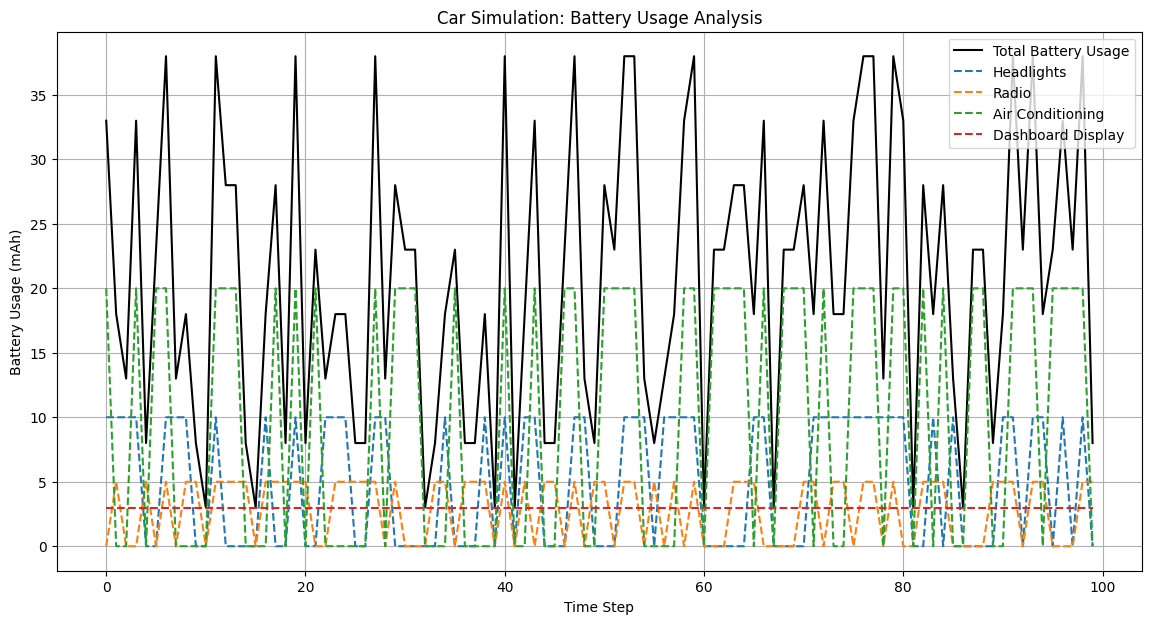

In [11]:
import pandas as pd
import random
import matplotlib.pyplot as plt

def generate_detailed_car_simulation_data(steps=100):
    columns = [
        'Time Step',
        'Total Battery Usage (mAh)',
        'Battery Usage - Headlights (mAh)',
        'Battery Usage - Radio (mAh)',
        'Battery Usage - Air Conditioning (mAh)',
        'Battery Usage - Dashboard Display (mAh)',
        'Brake Pressure (%)',
        'Motor Recoil (units)',
        'Accelerator Pressure (%)',
        'Steering Feedback (axis value)',
        'Speed (km/h)',
        'Engine Temperature (°C)',
        'Fuel Level (%)',
        'Tire Pressure (PSI)',
        'Odometer (km)'
    ]
    
    data_rows = []  # Accumulate rows in a list
    
    speed = 0
    odometer = 0
    
    battery_consumption_rates = {
        'Headlights': 10,
        'Radio': 5,
        'Air Conditioning': 20,
        'Dashboard Display': 3
    }
    
    for step in range(steps):
        battery_usage_headlights = battery_consumption_rates['Headlights'] * random.randint(0, 1)
        battery_usage_radio = battery_consumption_rates['Radio'] * random.randint(0, 1)
        battery_usage_ac = battery_consumption_rates['Air Conditioning'] * random.randint(0, 1)
        battery_usage_dashboard = battery_consumption_rates['Dashboard Display']
        
        total_battery_usage = sum([battery_usage_headlights, battery_usage_radio, battery_usage_ac, battery_usage_dashboard])
        
        brake_pressure = random.randint(0, 100)
        motor_recoil = random.randint(0, 50)
        accelerator_pressure = random.randint(0, 100)
        steering_feedback = random.uniform(-1, 1)
        speed = max(0, speed + accelerator_pressure/100 - brake_pressure/100)
        engine_temperature = random.randint(60, 100)
        fuel_level = max(0, 100 - step * 0.1)
        tire_pressure = random.randint(30, 35)
        odometer += speed / 60
        
        data_rows.append([
            step,
            total_battery_usage,
            battery_usage_headlights,
            battery_usage_radio,
            battery_usage_ac,
            battery_usage_dashboard,
            brake_pressure,
            motor_recoil,
            accelerator_pressure,
            steering_feedback,
            speed,
            engine_temperature,
            fuel_level,
            tire_pressure,
            odometer
        ])
    
    df = pd.DataFrame(data_rows, columns=columns)
    return df

# Generate and save the detailed simulation data
detailed_car_simulation_df = generate_detailed_car_simulation_data(100)
detailed_car_simulation_df.to_csv('detailed_car_simulation_data.csv', index=False)

# Plotting the data
plt.figure(figsize=(14, 7))

# Total Battery Usage
plt.plot(detailed_car_simulation_df['Time Step'], detailed_car_simulation_df['Total Battery Usage (mAh)'], label='Total Battery Usage', color='black')

# Individual components
plt.plot(detailed_car_simulation_df['Time Step'], detailed_car_simulation_df['Battery Usage - Headlights (mAh)'], label='Headlights', linestyle='--')
plt.plot(detailed_car_simulation_df['Time Step'], detailed_car_simulation_df['Battery Usage - Radio (mAh)'], label='Radio', linestyle='--')
plt.plot(detailed_car_simulation_df['Time Step'], detailed_car_simulation_df['Battery Usage - Air Conditioning (mAh)'], label='Air Conditioning', linestyle='--')
plt.plot(detailed_car_simulation_df['Time Step'], detailed_car_simulation_df['Battery Usage - Dashboard Display (mAh)'], label='Dashboard Display', linestyle='--')

plt.title('Car Simulation: Battery Usage Analysis')
plt.xlabel('Time Step')
plt.ylabel('Battery Usage (mAh)')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
detailed_car_simulation_df.columns

Index(['Time Step', 'Total Battery Usage (mAh)',
       'Battery Usage - Headlights (mAh)', 'Battery Usage - Radio (mAh)',
       'Battery Usage - Air Conditioning (mAh)',
       'Battery Usage - Dashboard Display (mAh)', 'Brake Pressure (%)',
       'Motor Recoil (units)', 'Accelerator Pressure (%)',
       'Steering Feedback (axis value)', 'Speed (km/h)',
       'Engine Temperature (°C)', 'Fuel Level (%)', 'Tire Pressure (PSI)',
       'Odometer (km)'],
      dtype='object')

In [14]:
# Generate a DataFrame similar to detailed_car_simulation_df for demonstration
np.random.seed(42)
time_steps = 100
detailed_car_simulation_df = pd.DataFrame({
    'Time Step': np.arange(time_steps),
    'Total Battery Usage (mAh)': np.random.randint(1000, 5000, size=time_steps).cumsum(),
    'Battery Usage - Headlights (mAh)': np.random.randint(10, 30, size=time_steps),
    'Battery Usage - Radio (mAh)': np.random.randint(5, 15, size=time_steps),
    'Battery Usage - Air Conditioning (mAh)': np.random.randint(20, 50, size=time_steps),
    'Battery Usage - Dashboard Display (mAh)': np.random.randint(5, 10, size=time_steps),
    'Brake Pressure (%)': np.random.randint(0, 100, size=time_steps),
    'Motor Recoil (units)': np.random.randint(0, 50, size=time_steps),
    'Accelerator Pressure (%)': np.random.randint(0, 100, size=time_steps),
    'Steering Feedback (axis value)': np.random.uniform(-1, 1, size=time_steps),
    'Speed (km/h)': np.random.uniform(0, 120, size=time_steps),
    'Engine Temperature (°C)': np.random.randint(20, 100, size=time_steps),
    'Fuel Level (%)': np.linspace(100, 0, time_steps),
    'Tire Pressure (PSI)': np.random.randint(30, 35, size=time_steps),
    'Odometer (km)': np.linspace(0, 500, time_steps)
})


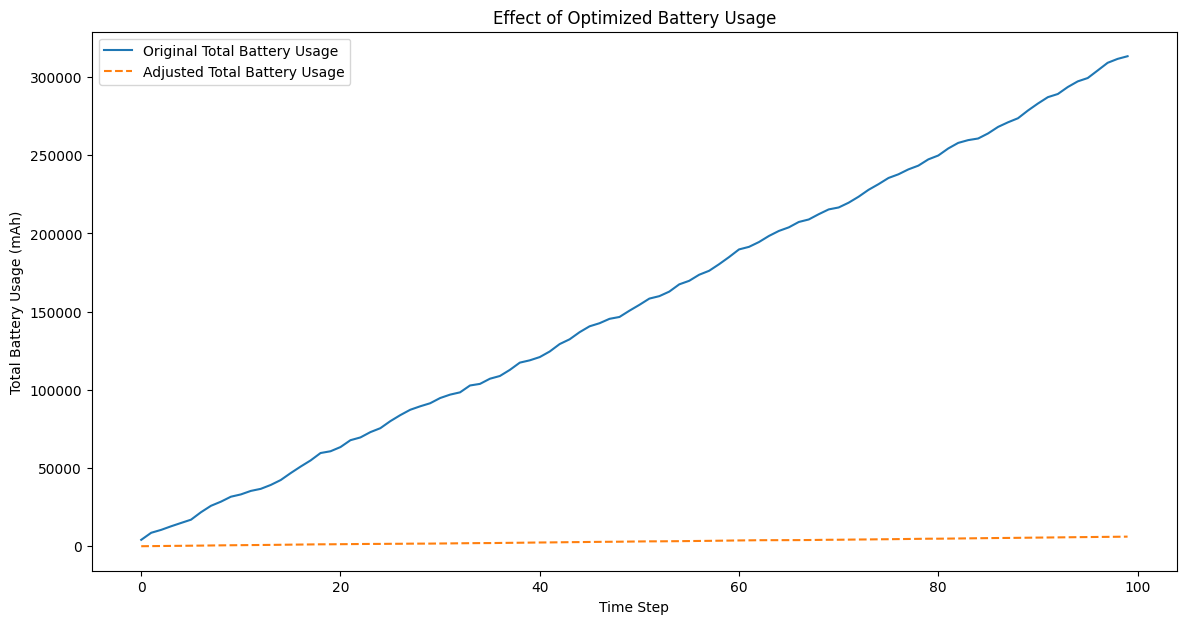

In [15]:
# Example strategy: Turn off Air Conditioning and Headlights when speed is below a threshold
speed_threshold = 20  # km/h

# Copy the DataFrame to modify
optimized_df = detailed_car_simulation_df.copy()

# Apply the strategy
optimized_df.loc[optimized_df['Speed (km/h)'] < speed_threshold, ['Battery Usage - Air Conditioning (mAh)', 'Battery Usage - Headlights (mAh)']] = 0

# Calculate the adjusted total battery usage after applying the strategy
optimized_df['Adjusted Total Battery Usage (mAh)'] = optimized_df[['Battery Usage - Headlights (mAh)', 'Battery Usage - Radio (mAh)', 'Battery Usage - Air Conditioning (mAh)', 'Battery Usage - Dashboard Display (mAh)']].sum(axis=1).cumsum()

# Plot the original vs adjusted total battery usage
plt.figure(figsize=(14, 7))
plt.plot(detailed_car_simulation_df['Time Step'], detailed_car_simulation_df['Total Battery Usage (mAh)'], label='Original Total Battery Usage')
plt.plot(optimized_df['Time Step'], optimized_df['Adjusted Total Battery Usage (mAh)'], label='Adjusted Total Battery Usage', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Total Battery Usage (mAh)')
plt.legend()
plt.title('Effect of Optimized Battery Usage')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # For reproducibility
time_steps = 100
speeds = np.random.uniform(0, 120, size=time_steps)  # Simulated car speeds
detailed_car_simulation_df = pd.DataFrame({
    'Time Step': np.arange(time_steps),
    'Total Battery Usage (mAh)': np.random.randint(1000, 5000, size=time_steps).cumsum(),
    'Battery Usage - Headlights (mAh)': np.random.randint(10, 30, size=time_steps),
    'Battery Usage - Radio (mAh)': np.random.randint(5, 15, size=time_steps),
    'Battery Usage - Air Conditioning (mAh)': np.random.randint(20, 50, size=time_steps),
    'Battery Usage - Dashboard Display (mAh)': np.random.randint(5, 10, size=time_steps),
    'Speed (km/h)': speeds,
    # Additional columns can be added here based on the provided structure
})

# Calculate the distance moved between consecutive points in the estimated_path
distances = np.linalg.norm(np.diff(estimated_path, axis=0), axis=1)
distances = np.insert(distances, 0, 0)  # Insert a 0 at the beginning to keep array sizes consistent

# Implement strategy: Turn off AC and Headlights if the car is moving slowly or stationary
slow_speed_threshold = 20  # km/h
movement_threshold = 5  # Arbitrary units; adjust based on estimated_path scale

for i, row in detailed_car_simulation_df.iterrows():
    if row['Speed (km/h)'] < slow_speed_threshold or distances[i] < movement_threshold:
        detailed_car_simulation_df.at[i, 'Battery Usage - Air Conditioning (mAh)'] = 0
        detailed_car_simulation_df.at[i, 'Battery Usage - Headlights (mAh)'] = 0

# Recalculate the Total Battery Usage after adjustments
component_columns = ['Battery Usage - Headlights (mAh)', 'Battery Usage - Radio (mAh)', 
                     'Battery Usage - Air Conditioning (mAh)', 'Battery Usage - Dashboard Display (mAh)']
detailed_car_simulation_df['Adjusted Total Battery Usage (mAh)'] = detailed_car_simulation_df[component_columns].sum(axis=1).cumsum()

# Visualization
plt.figure(figsize=(14, 7))
plt.plot(detailed_car_simulation_df['Time Step'], detailed_car_simulation_df['Total Battery Usage (mAh)'], label='Original Total Battery Usage')
plt.plot(detailed_car_simulation_df['Time Step'], detailed_car_simulation_df['Adjusted Total Battery Usage (mAh)'], label='Adjusted Total Battery Usage', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Total Battery Usage (mAh)')
plt.title('Battery Usage Before and After Optimization')
plt.legend()
plt.show()

# Plot the trajectory for visual inspection
plt.figure(figsize=(14, 7))
plt.plot(estimated_path[:, 0], estimated_path[:, 1], marker='o', linestyle='-', label='Estimated Path')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Estimated Car Path')
plt.legend()
plt.show()


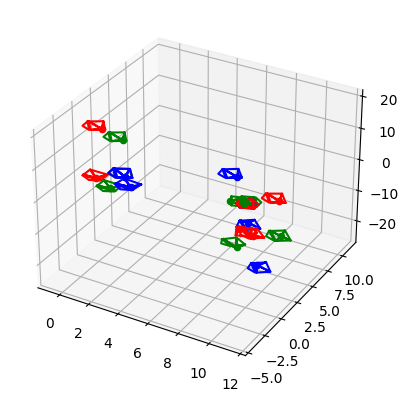

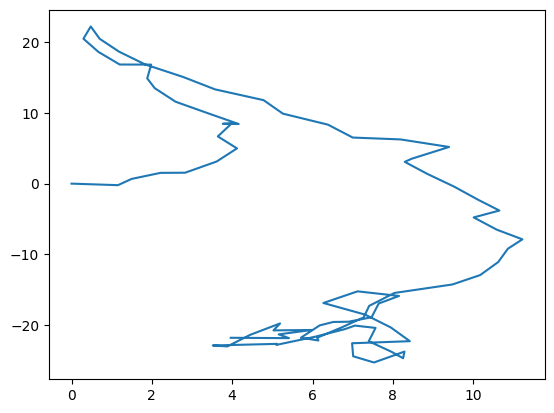

In [1]:
import numpy as np
import pandas as pd

class VehicleSimulator:
    def __init__(self):
        # Initialize all parameters to their starting values
        self.time_step = 0
        self.total_battery_usage = 10000  # Starting with a full battery for simplicity (mAh)
        self.battery_usage_headlights = 0
        self.battery_usage_radio = 0
        self.battery_usage_air_conditioning = 0
        self.battery_usage_dashboard_display = 0
        self.brake_pressure = 0
        self.motor_recoil = 0
        self.accelerator_pressure = 0
        self.steering_feedback = 0
        self.speed = 0
        self.engine_temperature = 20  # Assuming a starting temperature of 20°C
        self.fuel_level = 100  # Starting with a full tank (%)
        self.tire_pressure = 32  # PSI
        self.odometer = 0  # km

    def update(self):
        # Increment time step
        self.time_step += 1
        # Simulate changes in vehicle parameters here. This is highly simplified.
        self.speed = np.random.randint(0, 120)  # Random speed between 0 and 120 km/h
        self.fuel_level -= 0.05  # Simple fuel consumption model
        self.odometer += self.speed / 60  # Assuming one minute per time step
        # Update other parameters similarly based on your simulation logic

    def get_current_state(self):
        # Return the current state as a dictionary
        return {
            'Time Step': self.time_step,
            'Total Battery Usage (mAh)': self.total_battery_usage,
            'Battery Usage - Headlights (mAh)': self.battery_usage_headlights,
            'Battery Usage - Radio (mAh)': self.battery_usage_radio,
            'Battery Usage - Air Conditioning (mAh)': self.battery_usage_air_conditioning,
            'Battery Usage - Dashboard Display (mAh)': self.battery_usage_dashboard_display,
            'Brake Pressure (%)': self.brake_pressure,
            'Motor Recoil (units)': self.motor_recoil,
            'Accelerator Pressure (%)': self.accelerator_pressure,
            'Steering Feedback (axis value)': self.steering_feedback,
            'Speed (km/h)': self.speed,
            'Engine Temperature (°C)': self.engine_temperature,
            'Fuel Level (%)': self.fuel_level,
            'Tire Pressure (PSI)': self.tire_pressure,
            'Odometer (km)': self.odometer,
        }

# Example usage within your main loop
simulator = VehicleSimulator()
records = []
import os
import numpy as np
import cv2
from sympy import homogeneous_order

from tqdm import tqdm
import time

from matplotlib import pyplot as plt

import pytransform3d.transformations as pt
import pytransform3d.trajectories as ptr
import pytransform3d.rotations as pr
import pytransform3d.camera as pc

from cycler import cycle
   



class CameraPoses():
    
    def __init__(self, data_dir, skip_frames, intrinsic):
        
        self.K = intrinsic
        self.extrinsic = np.array(((1,0,0,0),(0,1,0,0),(0,0,1,0)))
        self.P = self.K @ self.extrinsic
        self.orb = cv2.ORB_create(3000)
        FLANN_INDEX_LSH = 6
        index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
        search_params = dict(checks=50)
        self.flann = cv2.FlannBasedMatcher(indexParams=index_params, searchParams=search_params)
        
        self.world_points = []

        self.current_pose = None
        
    @staticmethod
    def _load_images(filepath, skip_frames):
    
        image_paths = [os.path.join(filepath, file) for file in sorted(os.listdir(filepath))]
        images = []
        
        for path in tqdm(image_paths[::skip_frames]):
            img = cv2.imread(path)
            if img is not None:
                #images.append(cv2.resize(img, (640,480)))
                images.append(img)
                
        return images
    

    @staticmethod
    def _form_transf(R, t):
        
        T = np.eye(4, dtype=np.float64)
        T[:3, :3] = R
        T[:3, 3] = t
        
        return T

    def get_world_points(self):
        return np.array(self.world_points)
    
    def get_matches(self, img1, img2):
   
        # Find the keypoints and descriptors with ORB
        kp1, des1 = self.orb.detectAndCompute(img1, None)
        kp2, des2 = self.orb.detectAndCompute(img2, None)
        # Find matches
        if len(kp1) > 6 and len(kp2) > 6:
            matches = self.flann.knnMatch(des1, des2, k=2)

            # Find the matches there do not have a to high distance
            good_matches = []
            try:
                for m, n in matches:
                    if m.distance < 0.5 * n.distance:
                        good_matches.append(m)
            except ValueError:
                pass
            
            # Draw matches
            img_matches = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1] + img2.shape[1], 3), dtype=np.uint8)
            #cv2.drawMatches(img1, kp1, img2, kp2, good_matches, img_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
            #cv2.imshow('Good Matches', img_matches)
            #cv2.waitKey(50)
            
            # Get the image points form the good matches
            #q1 = [kp1[m.queryIdx] for m in good_matches]
            #q2 = [kp2[m.trainIdx] for m in good_matches]
            q1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
            q2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])
        
            return q1, q2
        else:
            return None, None

    def get_pose(self, q1, q2):
    
        # Essential matrix
        E, mask = cv2.findEssentialMat(q1, q2, self.K)

        # Decompose the Essential matrix into R and t
        R, t = self.decomp_essential_mat_old(E, q1, q2)

        # Get transformation matrix
        transformation_matrix = self._form_transf(R, np.squeeze(t))
        
        return transformation_matrix


    def decomp_essential_mat(self, E, q1, q2):

        R1, R2, t = cv2.decomposeEssentialMat(E)
        T1 = self._form_transf(R1,np.ndarray.flatten(t))
        T2 = self._form_transf(R2,np.ndarray.flatten(t))
        T3 = self._form_transf(R1,np.ndarray.flatten(-t))
        T4 = self._form_transf(R2,np.ndarray.flatten(-t))
        transformations = [T1, T2, T3, T4]
        
        # Homogenize K
        K = np.concatenate((self.K, np.zeros((3,1)) ), axis = 1)

        # List of projections
        projections = [K @ T1, K @ T2, K @ T3, K @ T4]

        np.set_printoptions(suppress=True)

        # print ("\nTransform 1\n" +  str(T1))
        # print ("\nTransform 2\n" +  str(T2))
        # print ("\nTransform 3\n" +  str(T3))
        # print ("\nTransform 4\n" +  str(T4))

        positives = []
        for P, T in zip(projections, transformations):
            hom_Q1 = cv2.triangulatePoints(P, P, q1.T, q2.T)
            hom_Q2 = T @ hom_Q1
            # Un-homogenize
            Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
            Q2 = hom_Q2[:3, :] / hom_Q2[3, :]
             
            total_sum = sum(Q2[2, :] > 0) + sum(Q1[2, :] > 0)
            relative_scale = np.mean(np.linalg.norm(Q1.T[:-1] - Q1.T[1:], axis=-1)/
                                     np.linalg.norm(Q2.T[:-1] - Q2.T[1:], axis=-1))
            positives.append(total_sum + relative_scale)
            

        # Decompose the Essential matrix using built in OpenCV function
        # Form the 4 possible transformation matrix T from R1, R2, and t
        # Create projection matrix using each T, and triangulate points hom_Q1
        # Transform hom_Q1 to second camera using T to create hom_Q2
        # Count how many points in hom_Q1 and hom_Q2 with positive z value
        # Return R and t pair which resulted in the most points with positive z

        max = np.argmax(positives)
        if (max == 2):
            # print(-t)
            return R1, np.ndarray.flatten(-t)
        elif (max == 3):
            # print(-t)
            return R2, np.ndarray.flatten(-t)
        elif (max == 0):
            # print(t)
            return R1, np.ndarray.flatten(t)
        elif (max == 1):
            # print(t)
            return R2, np.ndarray.flatten(t)
        
        
    def decomp_essential_mat_old(self, E, q1, q2):
        def sum_z_cal_relative_scale(R, t):
            # Get the transformation matrix
            T = self._form_transf(R, t)
            # Make the projection matrix
            P = np.matmul(np.concatenate((self.K, np.zeros((3, 1))), axis=1), T)

            # Triangulate the 3D points
            hom_Q1 = cv2.triangulatePoints(self.P, P, q1.T, q2.T)
            # Also seen from cam 2
            hom_Q2 = np.matmul(T, hom_Q1)

            # Un-homogenize
            Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
            Q2 = hom_Q2[:3, :] / hom_Q2[3, :]
            
            #self.world_points.append(Q1)

            # Find the number of points there has positive z coordinate in both cameras
            sum_of_pos_z_Q1 = sum(Q1[2, :] > 0)
            sum_of_pos_z_Q2 = sum(Q2[2, :] > 0)

            # Form point pairs and calculate the relative scale
            relative_scale = np.mean(np.linalg.norm(Q1.T[:-1] - Q1.T[1:], axis=-1)/
                                     np.linalg.norm(Q2.T[:-1] - Q2.T[1:], axis=-1))
            return sum_of_pos_z_Q1 + sum_of_pos_z_Q2, relative_scale

        # Decompose the essential matrix
        R1, R2, t = cv2.decomposeEssentialMat(E)
        t = np.squeeze(t)

        # Make a list of the different possible pairs
        pairs = [[R1, t], [R1, -t], [R2, t], [R2, -t]]

        # Check which solution there is the right one
        z_sums = []
        relative_scales = []
        for R, t in pairs:
            z_sum, scale = sum_z_cal_relative_scale(R, t)
            z_sums.append(z_sum)
            relative_scales.append(scale)

        # Select the pair there has the most points with positive z coordinate
        right_pair_idx = np.argmax(z_sums)
        right_pair = pairs[right_pair_idx]
        relative_scale = relative_scales[right_pair_idx]
        R1, t = right_pair
        t = t * relative_scale
        
        T = self._form_transf(R1, t)
        # Make the projection matrix
        P = np.matmul(np.concatenate((self.K, np.zeros((3, 1))), axis=1), T)

        # Triangulate the 3D points
        hom_Q1 = cv2.triangulatePoints(P, P, q1.T, q2.T)
        # Also seen from cam 2
        hom_Q2 = np.matmul(T, hom_Q1)

        # Un-homogenize
        Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
        Q2 = hom_Q2[:3, :] / hom_Q2[3, :]
        
        self.world_points.append(Q1)

        return [R1, t]



with open(r'C:\Users\16577\Downloads\ComputerVision-master (1)\ComputerVision-master\LiveCameraTrajectory\intrinsicNew.npy', 'rb') as f:
    intrinsic = np.load(f)


skip_frames = 2
data_dir = ''
vo = CameraPoses(data_dir, skip_frames, intrinsic)

gt_path = []
estimated_path = []
camera_pose_list = []
start_pose = np.ones((3,4))
start_translation = np.zeros((3,1))
start_rotation = np.identity(3)
start_pose = np.concatenate((start_rotation, start_translation), axis=1)
#print("Start pose: ", start_pose)

cap = cv2.VideoCapture(1)

# Check if camera opened successfully
if cap.isOpened() == False:
  print("Error opening video stream")
  

process_frames = False
old_frame = None
new_frame = None
frame_counter = 0

cur_pose = start_pose
def main_simulation_loop():
    # Initialize the simulator and the camera poses estimation
    simulator = VehicleSimulator()
    records = []
    
    # Load intrinsic parameters if available or define a dummy
    try:
        with open('intrinsic.npy', 'rb') as f:
            intrinsic = np.load(f)
    except FileNotFoundError:
        intrinsic = np.eye(3)  # Placeholder intrinsic matrix

    data_dir = ''  # Define your data directory
    skip_frames = 2
    vo = CameraPoses(data_dir, skip_frames, intrinsic)

    cap = cv2.VideoCapture(0)  # Adjust based on your camera setup
    if not cap.isOpened():
        print("Error opening video stream")
        return

    old_frame = None
    process_frames = False
  
while(cap.isOpened()):
    
    


    simulator.update()  # Update the vehicle simulator
    records.append(simulator.get_current_state())
    # Capture frame-by-frame
    ret, new_frame = cap.read()
    
    frame_counter += 1
    
    start = time.perf_counter()
    
    if process_frames and ret:
        q1, q2 = vo.get_matches(old_frame, new_frame)
        if q1 is not None:
            if len(q1) > 20 and len(q2) > 20:
                transf = vo.get_pose(q1, q2)
                cur_pose = cur_pose @ transf
        
        hom_array = np.array([[0,0,0,1]])
        hom_camera_pose = np.concatenate((cur_pose,hom_array), axis=0)
        camera_pose_list.append(hom_camera_pose)
        estimated_path.append((cur_pose[0, 3], cur_pose[2, 3]))
        
        estimated_camera_pose_x, estimated_camera_pose_y = cur_pose[0, 3], cur_pose[2, 3]

    elif process_frames and ret is False:
        break
    
    old_frame = new_frame
    
    process_frames = True
    
    end = time.perf_counter()
    
    total_time = end - start
    fps = 1 / total_time
    
    cv2.putText(new_frame, f'FPS: {int(fps)}', (20,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    
    cv2.putText(new_frame, str(np.round(cur_pose[0, 0],2)), (260,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[0, 1],2)), (340,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[0, 2],2)), (420,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[1, 0],2)), (260,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[1, 1],2)), (340,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[1, 2],2)), (420,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[2, 0],2)), (260,130), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[2, 1],2)), (340,130), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[2, 2],2)), (420,130), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    
    cv2.putText(new_frame, str(np.round(cur_pose[0, 3],2)), (540,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[1, 3],2)), (540,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
    cv2.putText(new_frame, str(np.round(cur_pose[2, 3],2)), (540,130), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
    
    
    cv2.imshow("img", new_frame)
    
    #if frame_counter % 20 == 0:
        #print("FPS: ", fps)
        #print("Frames: ", frame_counter)
    
    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# When everything done, release the video capture object
cap.release()

  
  

number_of_frames = 20
image_size = np.array([640, 480])
#image_size = np.array([1920, 1080])

plt.figure()
#ax = pt.plot_transform()
ax = plt.axes(projection='3d')

camera_pose_poses = np.array(camera_pose_list)

df = pd.DataFrame(records)
df.to_csv('vehicle_simulation_data.csv', index=False)

key_frames_indices = np.linspace(0, len(camera_pose_poses) - 1, number_of_frames, dtype=int)
colors = cycle("rgb")

for i, c in zip(key_frames_indices, colors):
    pc.plot_camera(ax, vo.K, camera_pose_poses[i],
                   sensor_size=image_size, c=c)


plt.show()

take_every_th_camera_pose = 2

estimated_path = np.array(estimated_path[::take_every_th_camera_pose])

plt.plot(estimated_path[:,0],estimated_path[:,1])
plt.show()
    

